In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules, Settings & Functions|20

In [2]:
!python3 -m pip install --upgrade pip \
--user --quiet --no-warn-script-location
!python3 -m pip install --upgrade \
neural_structured_learning --user --quiet 

In [3]:
import os,h5py,urllib,pandas as pd,numpy as np
import tensorflow as tf,pylab as pl,seaborn as sn
import neural_structured_learning as nsl
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
file_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_name='Pictograms64.h5'
img_size=64
model_weights='/checkpoints'

In [4]:
def pd_style():
    return [dict(selector='th',
                 props=[('font-size','12pt'),('min-width','150px')]),
            dict(selector='td',
                 props=[('padding','0em 0em'),('min-width','150px')]),
            dict(selector='tr:hover th:hover',
                 props=[('font-size','14pt'),('max-width','150px'),
                        ('text-shadow','3px 3px 3px #aaa')]),
            dict(selector='tr:hover td:hover',
                 props=[('font-size','12pt'),('max-width','150px'),
                        ('text-shadow','3px 3px 3px #aaa')])]
def display_images(images,labels,names,n):
    fig=pl.figure(figsize=(9,n/2))
    randch=np.random.choice(images.shape[0],size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(int(n//5)+1,5,i+1,xticks=[],yticks=[])
        ax.imshow(images[idx],cmap='bone')
        label=[labels[:,idx]]
        name=[names[i][labels[i][idx]] 
              for i in range(labels.shape[0])]
        ti='{} \n {}'.format(str(label),str(name))
        ax.set_title(ti,fontsize=8)
    pl.tight_layout(); pl.show()

In [5]:
def h5file2data(h5file,img_size,
                resize=True,cmap='tab20',fig_size=7):
    with h5py.File(h5file,'r') as f:
        keys=list(f.keys()); print('file keys: '+', '.join(keys))
        images=np.array(f[keys[int(0)]],dtype='float32')
        labels=np.array(f[keys[int(1)]])
        names=[[el.decode('utf-8') for el in f[keys[i]]]
               for i in range(2,len(keys))]
        f.close()
    N=images.shape[0]; n=int(.1*N)
    if resize:
        images=tf.image.resize(images,[img_size,img_size]).numpy()
    shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    images=images[shuffle_ids]
    labels=np.array([labels[i][shuffle_ids] 
                     for i in range(labels.shape[0])])
    x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
    y_test,y_valid,y_train=labels[:,:n],labels[:,n:2*n],labels[:,2*n:]
    df=pd.DataFrame(
        [[x_train.shape,x_valid.shape,x_test.shape],
         [x_train.dtype,x_valid.dtype,x_test.dtype],
         [y_train.shape,y_valid.shape,y_test.shape],
         [y_train.dtype,y_valid.dtype,y_test.dtype]],
        columns=['train','valid','test'],
        index=['image shape','image type','label shape','label type'])
    print('data outputs: ')
    display(df.style.set_table_styles(pd_style()))
    print('distribution of labels: ')
    idx=['labels %d'%(i+1) for i in range(labels.shape[0])]
    df=pd.DataFrame(labels,index=idx).T
    for i in range(labels.shape[0]):
        df['name %d'%(i+1)]=[names[i][l] for l in labels[i]]
    fig=pl.figure(figsize=(1.5*fig_size,fig_size))    
    for i in range(labels.shape[0]):
        ax=fig.add_subplot(labels.shape[0],1,i+1)
        sn.countplot(x='name %s'%(i+1),data=df,palette=cmap,alpha=.5,ax=ax)
    pl.tight_layout(); pl.show()       
    return [names,x_train,x_valid,x_test,y_train,y_valid,y_test]

In [6]:
def cb(mw):
    early_stopping=tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=20,verbose=2,mode='max')
    checkpointer=tf.keras.callbacks.ModelCheckpoint(
        save_best_only=True,save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        filepath=mw,verbose=2,mode='max')
    lr_reduction=tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_scaled_adversarial_loss',
        verbose=2,patience=10,factor=.8,mode='min')
    return [checkpointer,early_stopping,lr_reduction]
def keras_history_plot(
    fit_history,fig_size=9,color='darkblue'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(3,1,1)
    dfkeys.iloc[:,[0,4]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(3,1,2)
    dfkeys.iloc[:,[3,7]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    ax3=fig.add_subplot(3,1,3)
    dfkeys.iloc[:,[2,6]].plot(
        ax=ax3,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [7]:
%radial_gradient_header Data Loading|20

file keys: images, labels, names1, names2
data outputs: 


,train,valid,test
image shape,"(2837, 64, 64, 3)","(354, 64, 64, 3)","(354, 64, 64, 3)"
image type,float32,float32,float32
label shape,"(2, 2837)","(2, 354)","(2, 354)"
label type,int32,int32,int32


distribution of labels: 


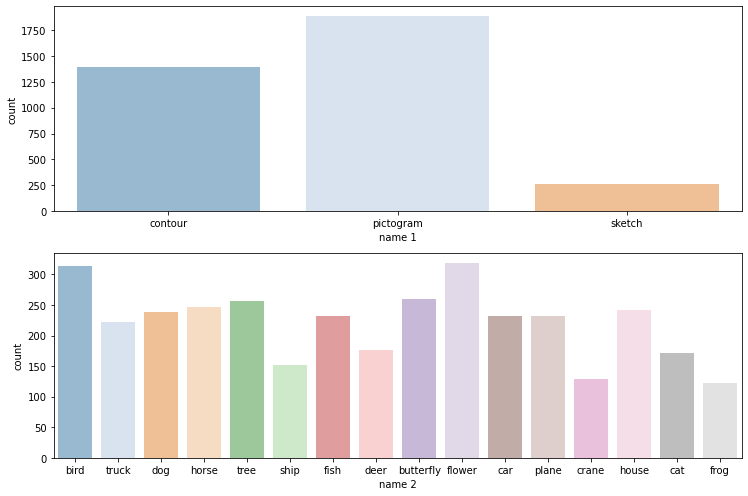

In [8]:
input_file=urllib.request.urlopen(file_path+file_name)
output_file=open(file_name,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
[names,x_train,x_valid,x_test,y_train,y_valid,y_test]=\
h5file2data(file_name,img_size)
num_classes=len(names[1])
os.remove(file_name)

In [9]:
%radial_gradient_header TF Data Processing|20

In [10]:
batch_size=16
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,
     'label':np.array(y_train[1],dtype='float32')}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,
     'label':np.array(y_valid[1],dtype='float32')}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size

In [11]:
%radial_gradient_header Models with Adversarial Regularization => MLP|20

In [12]:
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tkl.Flatten(),
    tkl.Dense(192,activation=tf.nn.relu),
    tkl.BatchNormalization(),    
    tkl.Dense(256,activation=tf.nn.relu),
    tkl.BatchNormalization(),    
    tkl.Dense(512,activation=tf.nn.relu),
    tkl.Dense(num_classes,activation=tf.nn.softmax)
])
adv_config=nsl.configs.make_adv_reg_config(
    multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras.AdversarialRegularization(
    base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [13]:
history=adv_model.fit(
    train,validation_data=valid,verbose=2,
    validation_steps=valid_steps,
    epochs=100,callbacks=cb(model_weights));

Epoch 1/100
178/178 - 11s - loss: 2.8569 - sparse_categorical_crossentropy: 2.3729 - sparse_categorical_accuracy: 0.2633 - scaled_adversarial_loss: 0.4839 - val_loss: 8.1037 - val_sparse_categorical_crossentropy: 6.7455 - val_sparse_categorical_accuracy: 0.0909 - val_scaled_adversarial_loss: 1.3582

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.09091, saving model to /checkpoints
Epoch 2/100
178/178 - 1s - loss: 2.1562 - sparse_categorical_crossentropy: 1.7892 - sparse_categorical_accuracy: 0.4381 - scaled_adversarial_loss: 0.3669 - val_loss: 4.8120 - val_sparse_categorical_crossentropy: 3.9993 - val_sparse_categorical_accuracy: 0.1875 - val_scaled_adversarial_loss: 0.8127

Epoch 00002: val_sparse_categorical_accuracy improved from 0.09091 to 0.18750, saving model to /checkpoints
Epoch 3/100
178/178 - 2s - loss: 1.6174 - sparse_categorical_crossentropy: 1.3384 - sparse_categorical_accuracy: 0.5777 - scaled_adversarial_loss: 0.2790 - val_loss: 6.5068 - val_sparse_

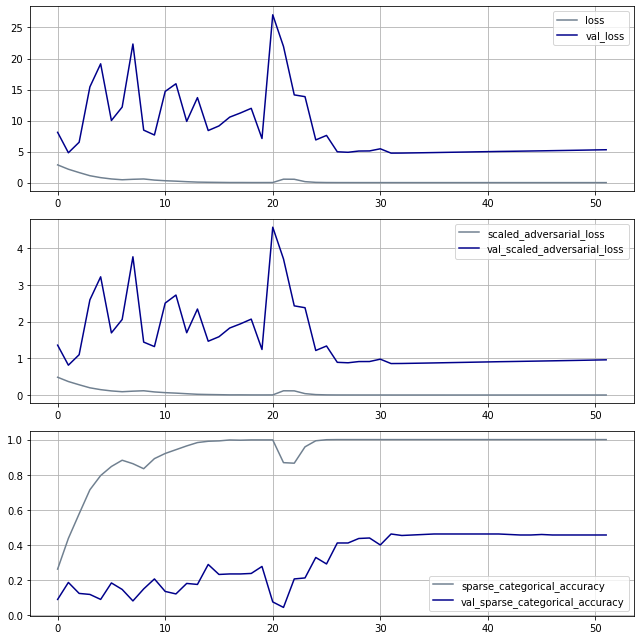

In [14]:
keras_history_plot(history)

In [15]:
adv_model.load_weights(model_weights)
dict(zip(adv_model.metrics_names,adv_model.evaluate(
    {'input':x_test,
     'label':np.array(y_test[1],dtype='float32')},
     verbose=0)))

{'loss': 4.734360694885254,
 'sparse_categorical_crossentropy': 3.8711719512939453,
 'sparse_categorical_accuracy': 0.42937853932380676,
 'scaled_adversarial_loss': 0.8631892204284668}

In [16]:
%radial_gradient_header Models with Adversarial Regularization => CNN|20

In [17]:
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [18]:
history=adv_model.fit(
    train,validation_data=valid,verbose=2,
    validation_steps=valid_steps,
    epochs=100,callbacks=cb(model_weights));

Epoch 1/100
178/178 - 6s - loss: 3.3127 - sparse_categorical_crossentropy: 2.7603 - sparse_categorical_accuracy: 0.0765 - scaled_adversarial_loss: 0.5524 - val_loss: 3.2676 - val_sparse_categorical_crossentropy: 2.7228 - val_sparse_categorical_accuracy: 0.0682 - val_scaled_adversarial_loss: 0.5448

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.06818, saving model to /checkpoints
Epoch 2/100
178/178 - 1s - loss: 3.2891 - sparse_categorical_crossentropy: 2.7405 - sparse_categorical_accuracy: 0.0807 - scaled_adversarial_loss: 0.5486 - val_loss: 3.2489 - val_sparse_categorical_crossentropy: 2.7071 - val_sparse_categorical_accuracy: 0.1051 - val_scaled_adversarial_loss: 0.5418

Epoch 00002: val_sparse_categorical_accuracy improved from 0.06818 to 0.10511, saving model to /checkpoints
Epoch 3/100
178/178 - 1s - loss: 3.2797 - sparse_categorical_crossentropy: 2.7331 - sparse_categorical_accuracy: 0.0885 - scaled_adversarial_loss: 0.5466 - val_loss: 3.2146 - val_sparse_c

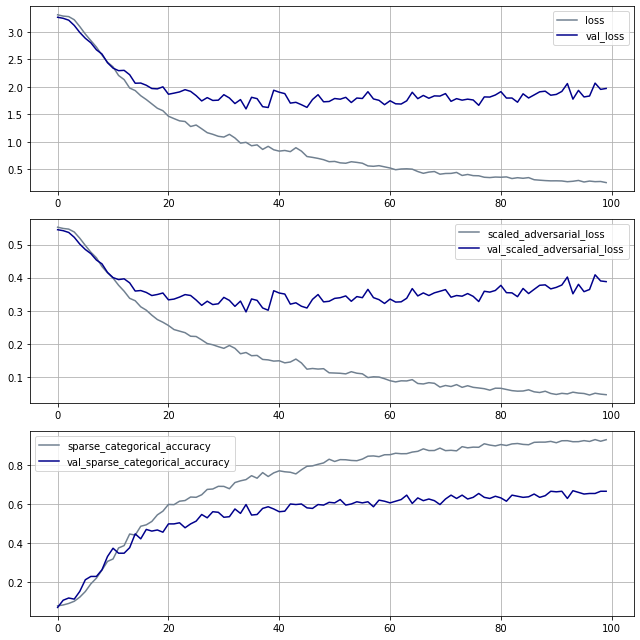

In [19]:
keras_history_plot(history)

In [20]:
adv_model.load_weights(model_weights)
dict(zip(adv_model.metrics_names,adv_model.evaluate(
    {'input':x_test,
     'label':np.array(y_test[1],dtype='float32')},
     verbose=0)))

{'loss': 2.0145328044891357,
 'sparse_categorical_crossentropy': 1.6188024282455444,
 'sparse_categorical_accuracy': 0.6525423526763916,
 'scaled_adversarial_loss': 0.39573046565055847}